In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [105]:
ROOT_RAWDATA_PATH = Path("/Users/spencer/motor-control/data/rawdata/")
ROOT_METADATA_PATH = Path("/Users/spencer/motor-control/data/metadata/")

def get_calibration_filenames(collection_name, subject_name, session_name):
    directory = (
        ROOT_RAWDATA_PATH
        / collection_name
        / subject_name
        / "calibration_bars"
        / session_name
    )
    filenames = []
    for filename in directory.iterdir():
        if ("_bars_" in str(filename) and not "csv" in str(filename)):
            filenames.append(filename)
    filenames.sort(key=lambda x: int(x.name.split("/")[-1].split("_")[0]))
    return filenames

def load_calibration_emg(filename):
    return (
        np.fromfile(filename, dtype="<f4").reshape(-1, 64)
    )

def load_subject_calibration_stack(subject):
    stack = np.empty(shape=(2,32,64,1000))
    stack[:] = np.nan
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = get_calibration_filenames(collection_name, subject.name, session_name)
        for bar_idx, filename in enumerate(filenames):
            e = load_calibration_emg(filename)
            # subtract off the lowpoint from the trial
            low_point = np.argmin(np.linalg.norm(e,axis=1))
            e -= e[low_point]
            # trim the signal ends
            e = e[200:720,:]
            # subset the data that's 1 std above (active movement)
            indices = find_std_mask(e.T)
            e = e[indices]
            # stuff this into stack array
            stack[session_idx, bar_idx, :, :e.shape[0]] = e.T
    return np.array(stack)

def find_std_mask(array):
    assert array.shape[0] == 64
    assert array.shape[1] > 100

    # norm over channels
    sig_norms = np.linalg.norm(array,axis=0)

    # find stddev
    std_norm = np.nanstd(sig_norms)

    # compute boolean mask based on std
    mask = sig_norms > std_norm
    
    indices = np.arange(sig_norms.shape[0])[mask]

    return indices

## plot the mean signals with stddev subset

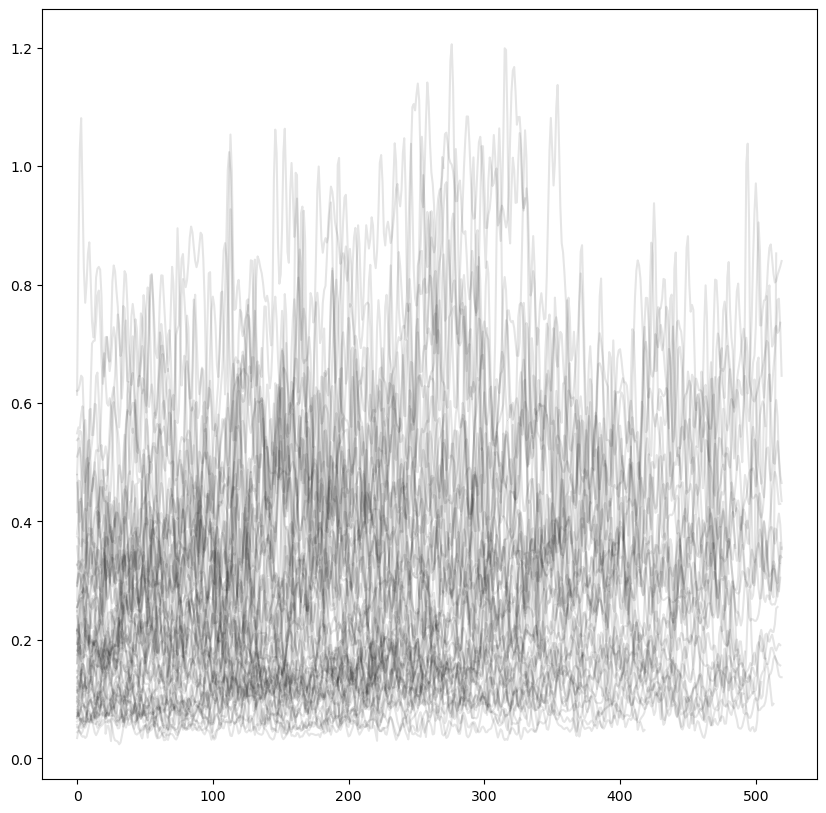

In [106]:
stack = load_subject_calibration_stack(subjects[0])

plt.figure(figsize=(10,10))
for trial in stack.reshape(64,64,-1):
    # plot the mean
    mu = np.mean(trial,axis=0)
    plt.plot(mu,"k",alpha=0.1)

In [107]:
subject_calibration_stacks = []
for subject in subjects:
    subject_calibration_stacks.append(load_subject_calibration_stack(subject))
subject_calibration_stacks = np.array(subject_calibration_stacks)
print(subject_calibration_stacks.shape)
np.save("subject_calibration_stacks.npy",subject_calibration_stacks)

(46, 2, 32, 64, 1000)


In [108]:
subject_calibration_stacks = np.load("subject_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

(46, 2, 32, 64, 1000)
